# モデルの訓練
画像識別アプリで使用する、CNNのモデルを訓練し保存します。  
今回は訓練データにCIFAR-10を使用します。  


## データの前処理
CIFAR-10を読み込んで、データ拡張とともにDataLoaderの設定を行います。  

In [1]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

affine = transforms.RandomAffine([-15, 15], scale=(0.8, 1.2))  # 回転とリサイズ
flip = transforms.RandomHorizontalFlip(p=0.5)  # 左右反転
normalize = transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))  # 平均値を0、標準偏差を1に
to_tensor = transforms.ToTensor()

transform_train = transforms.Compose([affine, flip, to_tensor, normalize])
transform_test = transforms.Compose([to_tensor, normalize])
cifar10_train = CIFAR10("./data", train=True, download=True, transform=transform_train)
cifar10_test = CIFAR10("./data", train=False, download=True, transform=transform_test)

# DataLoaderの設定
batch_size = 64
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=len(cifar10_test), shuffle=False)

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## モデルの構築
`nn.Module`モジュールを継承したクラスとして、CNNのモデルを構築します。   

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # 畳み込み層:(入力チャンネル数, フィルタ数、フィルタサイズ)
        self.pool = nn.MaxPool2d(2, 2)  # プーリング層:（領域のサイズ, ストライド）
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 256)  # 全結合層
        self.dropout = nn.Dropout(p=0.5)  # ドロップアウト:(p=ドロップアウト率)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

net = Net()
net.cuda()  # GPU対応
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


## 学習
モデルを訓練します。   
学習には時間がかかりますので、編集→ノートブックの設定のハードウェアアクセラレーターでGPUを選択しましょう。


In [3]:
from torch import optim

# 交差エントロピー誤差関数
loss_fnc = nn.CrossEntropyLoss()

# 最適化アルゴリズム
optimizer = optim.Adam(net.parameters())

# 損失のログ
record_loss_train = []
record_loss_test = []

# 学習
x_test, t_test = iter(test_loader).next()
x_test, t_test = x_test.cuda(), t_test.cuda()
for i in range(20):  # 20エポック学習
    net.train()  # 訓練モード
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # ミニバッチ（x, t）を取り出す
        x, t = x.cuda(), t.cuda()  # GPU対応
        y = net(x)
        loss = loss_fnc(y, t)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    net.eval()  # 評価モード
    y_test = net(x_test)
    loss_test = loss_fnc(y_test, t_test).item()
    record_loss_test.append(loss_test)

    if i%1 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)

Epoch: 0 Loss_Train: 1.8128828907866612 Loss_Test: 1.5537400245666504
Epoch: 1 Loss_Train: 1.5702826165787094 Loss_Test: 1.428728461265564
Epoch: 2 Loss_Train: 1.5009533380303541 Loss_Test: 1.3760608434677124
Epoch: 3 Loss_Train: 1.4460583847502004 Loss_Test: 1.3263911008834839
Epoch: 4 Loss_Train: 1.4027973122304054 Loss_Test: 1.2627460956573486
Epoch: 5 Loss_Train: 1.3816258600910607 Loss_Test: 1.241010069847107
Epoch: 6 Loss_Train: 1.3552677812783613 Loss_Test: 1.2576247453689575
Epoch: 7 Loss_Train: 1.3331189535158066 Loss_Test: 1.340861201286316
Epoch: 8 Loss_Train: 1.3262240811991874 Loss_Test: 1.1821485757827759
Epoch: 9 Loss_Train: 1.3071729996625114 Loss_Test: 1.1729722023010254
Epoch: 10 Loss_Train: 1.292255433624053 Loss_Test: 1.1616966724395752
Epoch: 11 Loss_Train: 1.2766128622205055 Loss_Test: 1.1501559019088745
Epoch: 12 Loss_Train: 1.2698971840274302 Loss_Test: 1.129800796508789
Epoch: 13 Loss_Train: 1.2612430610315268 Loss_Test: 1.1596050262451172
Epoch: 14 Loss_Train:

## 誤差の推移
訓練データ、テストデータで誤差の推移をグラフ表示します。  

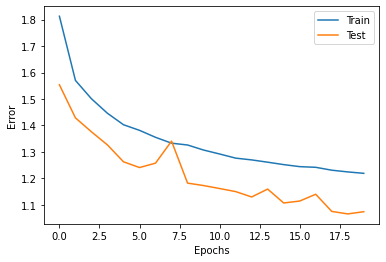

In [4]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

## 正解率
モデルの性能を把握するため、テストデータ使い正解率を測定します。  

In [5]:
correct = 0
total = 0
net.eval()  # 評価モード
for i, (x, t) in enumerate(test_loader):
    x, t = x.cuda(), t.cuda()  # GPU対応
    y = net(x)
    correct += (y.argmax(1) == t).sum().item()
    total += len(x)
print("正解率:", str(correct/total*100) + "%")

正解率: 61.760000000000005%


## モデルの保存
訓練済みモデルのパラメータを保存します。    
`state_dict()`によりモデルの各パラメータが取得できるので、これを保存します。

In [6]:
import torch

# state_dict()の表示
for key in net.state_dict():
    print(key, ": ", net.state_dict()[key].size())
print(net.state_dict()["conv1.weight"][0])  # 　パラメータの一部を表示

# 保存
torch.save(net.state_dict(), "model_cnn.pth")  

conv1.weight :  torch.Size([6, 3, 5, 5])
conv1.bias :  torch.Size([6])
conv2.weight :  torch.Size([16, 6, 5, 5])
conv2.bias :  torch.Size([16])
fc1.weight :  torch.Size([256, 400])
fc1.bias :  torch.Size([256])
fc2.weight :  torch.Size([10, 256])
fc2.bias :  torch.Size([10])
tensor([[[ 0.0785, -0.0642,  0.0462,  0.0375,  0.0063],
         [-0.0288,  0.0815, -0.0749, -0.0305,  0.0573],
         [ 0.0224, -0.0151,  0.0309, -0.0405, -0.0659],
         [ 0.0438, -0.0215,  0.0707, -0.0278,  0.0589],
         [ 0.0363, -0.0473, -0.1151, -0.0951,  0.0031]],

        [[-0.1775, -0.0341, -0.0425, -0.1066, -0.0590],
         [-0.0447, -0.1469, -0.0370, -0.1192,  0.0102],
         [-0.0700, -0.0342,  0.0107, -0.0345, -0.0115],
         [-0.1764, -0.0919, -0.1297, -0.1386, -0.0262],
         [-0.0068,  0.0121,  0.0372, -0.0324, -0.0817]],

        [[ 0.0955,  0.1410,  0.1564,  0.2040,  0.0697],
         [ 0.0092,  0.0782,  0.0874,  0.2373,  0.0465],
         [-0.0169,  0.1570,  0.1496,  0.2327,  0

## モデルの読み込み
保存したパラメータを読み込み、モデルに設定します。  
`torch.load()`で`map_location`にCPUを指定することで、GPUで訓練したモデルをCPUで使用することが可能になります。  


In [7]:
# 読み込み
net_loaded = Net()
net_loaded.load_state_dict(torch.load("model_cnn.pth", map_location=torch.device("cpu")))  #CPU対応
net_loaded.eval()  # 評価モード

# state_dict()の表示
for key in net_loaded.state_dict():
    print(key, ": ", net.state_dict()[key].size())
print(net_loaded.state_dict()["conv1.weight"][0])  # 　パラメータの一部を表示

conv1.weight :  torch.Size([6, 3, 5, 5])
conv1.bias :  torch.Size([6])
conv2.weight :  torch.Size([16, 6, 5, 5])
conv2.bias :  torch.Size([16])
fc1.weight :  torch.Size([256, 400])
fc1.bias :  torch.Size([256])
fc2.weight :  torch.Size([10, 256])
fc2.bias :  torch.Size([10])
tensor([[[ 0.0785, -0.0642,  0.0462,  0.0375,  0.0063],
         [-0.0288,  0.0815, -0.0749, -0.0305,  0.0573],
         [ 0.0224, -0.0151,  0.0309, -0.0405, -0.0659],
         [ 0.0438, -0.0215,  0.0707, -0.0278,  0.0589],
         [ 0.0363, -0.0473, -0.1151, -0.0951,  0.0031]],

        [[-0.1775, -0.0341, -0.0425, -0.1066, -0.0590],
         [-0.0447, -0.1469, -0.0370, -0.1192,  0.0102],
         [-0.0700, -0.0342,  0.0107, -0.0345, -0.0115],
         [-0.1764, -0.0919, -0.1297, -0.1386, -0.0262],
         [-0.0068,  0.0121,  0.0372, -0.0324, -0.0817]],

        [[ 0.0955,  0.1410,  0.1564,  0.2040,  0.0697],
         [ 0.0092,  0.0782,  0.0874,  0.2373,  0.0465],
         [-0.0169,  0.1570,  0.1496,  0.2327,  0

モデルの各パラメータを保存し、読み込むことができました。